### 1.Importando e tratantdo dados


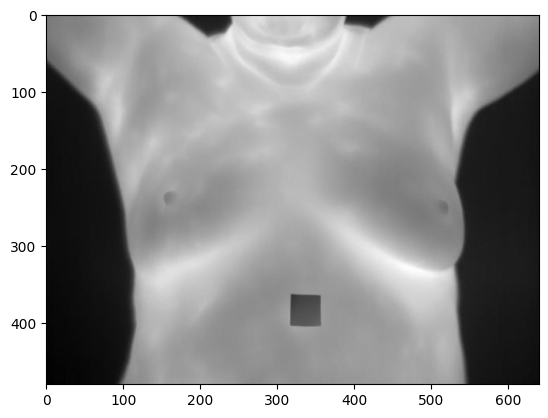

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import time
DATADIR="DATASETS/TCC-imagens-main/"
CATEGORIES= ["pacientes_COM_cancer", "pacientes_SEM_cancer"]

NAME = "Tcc_cnn_64_{}".format(int(time.time()))





for category in CATEGORIES:
    path = os.path.join(DATADIR, category) #path para as imagens
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array,cmap="gray")
        plt.show()
        break
    break

In [30]:
from tensorflow.keras.callbacks import TensorBoard


In [51]:
tensorBoard = TensorBoard(log_dir='log/{}'.format(NAME))

In [32]:
img_array.shape

(480, 640)

Novo vetor com as imagens no memo tamanho

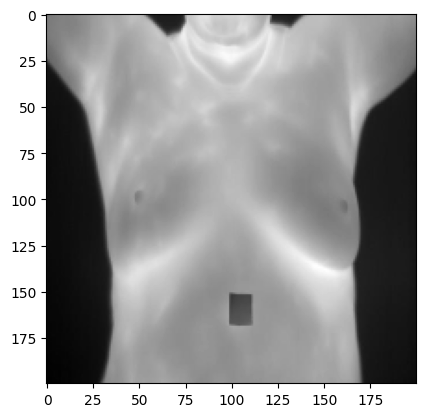

In [33]:
IMG_SIZE=200
new_array= cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_array,cmap="gray")
plt.show()

In [34]:
traning_data=[]

def create_traning_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category) #path para as imagens
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array= cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                traning_data.append([new_array,class_num])
            except Exception as e:
                pass


create_traning_data()

In [35]:
print(len(traning_data))

4530


In [36]:
import random
random.shuffle(traning_data)

In [37]:
for sample in traning_data[:10]:
    print(sample[1])

1
1
1
0
0
1
1
1
1
0


In [38]:
X = []
y = []

In [39]:
for features, label in traning_data:
    X.append(features)
    y.append(label)

x_train= np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,1)



In [40]:
import pickle

pickle_out = open("X.picle","wb")
pickle.dump(x_train,pickle_out)
pickle_out.close()

pickle_out = open("y.picle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

In [41]:
pickle_in =  open("x.picle","rb")
x_train2= pickle.load(pickle_in)

In [42]:
def normalize(x,m,s):
    return (x-m)/s

train_mean = x_train.mean()
train_std = x_train.std() 

In [43]:
X_train_norm = normalize(x_train, train_mean, train_std)
y = np.array(y)

In [44]:
print(f'Training Mean after standardization {X_train_norm.mean():.17f}')
print(f'Training Std after standardization {X_train_norm.std():.8f}')


Training Mean after standardization 0.00000000000000013
Training Std after standardization 1.00000000


### Gerando o modelo

##### O modelo é composto pelas seguintes camadas:
- Conv 2d com 60 caracteristicas imagens e um filtro 3/3
- max pool para refuzir o tamanho das imagens
- outra conv 2d para extraix caracteristicas da imagem nesse caso são 128
- outra max pool
- uma camada flattern para achatar os dados das anteriores
- Duas camadas densas para exrtrair características especificas (hidden layers)
- e uma camada de ativação com resposta 0 ou 1

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

model = Sequential([
    Conv2D(60,kernel_size=(3,3),input_shape=X_train_norm.shape[1:], activation='relu'),
    MaxPooling2D(),
    Conv2D(128,kernel_size=(3,3),activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(120,activation='relu'),
    Dense(200, activation='relu'),
    Dense(1, activation='sigmoid'),
])


In [63]:
del model

In [67]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 198, 198, 60)      600       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 99, 99, 60)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 97, 97, 128)       69248     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 48, 48, 128)      0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 294912)            0         
                                                                 
 dense_12 (Dense)            (None, 120)              

In [68]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy']
)

### Treinando o modelo

In [69]:
hist2 = model.fit(X_train_norm,y, validation_split=0.3, epochs=10, batch_size=32, callbacks=[tensorBoard])

Epoch 1/10
100/100 [==============================] - 8s 74ms/step - loss: 0.5447 - accuracy: 0.8127 - val_loss: 0.3018 - val_accuracy: 0.8374
Epoch 2/10
100/100 [==============================] - 7s 70ms/step - loss: 0.1659 - accuracy: 0.9344 - val_loss: 0.1682 - val_accuracy: 0.9375
Epoch 3/10
100/100 [==============================] - 7s 70ms/step - loss: 0.0867 - accuracy: 0.9681 - val_loss: 0.1830 - val_accuracy: 0.9360
Epoch 4/10
100/100 [==============================] - 7s 70ms/step - loss: 0.0512 - accuracy: 0.9779 - val_loss: 0.1946 - val_accuracy: 0.9389
Epoch 5/10
100/100 [==============================] - 7s 69ms/step - loss: 0.0255 - accuracy: 0.9921 - val_loss: 0.2246 - val_accuracy: 0.9404
Epoch 6/10
100/100 [==============================] - 7s 68ms/step - loss: 0.0228 - accuracy: 0.9915 - val_loss: 0.2348 - val_accuracy: 0.9367
Epoch 7/10
100/100 [==============================] - 7s 67ms/step - loss: 0.0233 - accuracy: 0.9927 - val_loss: 0.2405 - val_accuracy: 0.9352

In [71]:
import pandas as pd
pd.DataFrame(hist2.history)

,loss,accuracy,val_loss,val_accuracy
0,0.544694,0.812677,0.301835,0.837380
1,0.165919,0.934406,0.168228,0.937454
2,0.086663,0.968149,0.183035,0.935982
3,0.051191,0.977925,0.194624,0.938926
4,0.025507,0.992116,0.224608,0.940397
5,0.022833,0.991485,0.234766,0.936718
6,0.023263,0.992747,0.240468,0.935247
7,0.026201,0.990539,0.299217,0.930096
8,0.004724,0.998108,0.360350,0.935982
9,0.002448,0.998739,0.337914,0.940397


<Axes: >

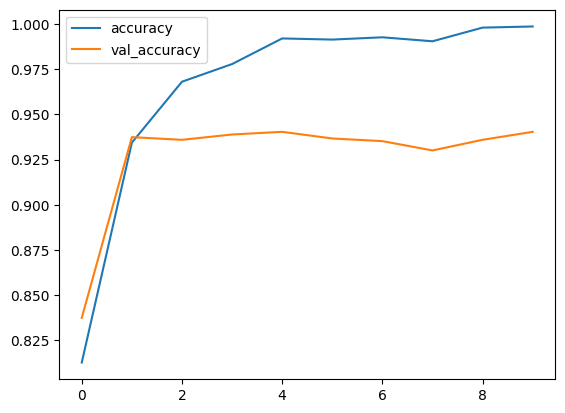

In [72]:
import pandas as pd

df = pd.DataFrame(hist2.history)

df[['accuracy', 'val_accuracy']].plot()

<Axes: >

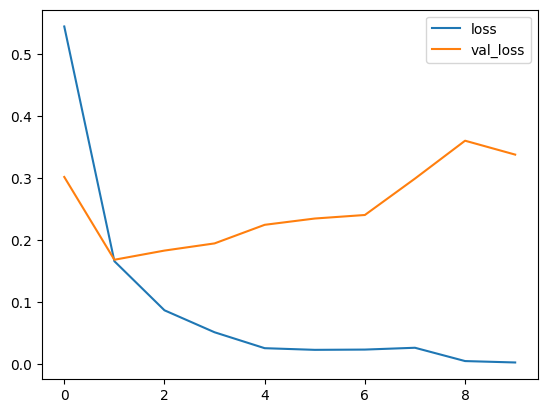

In [73]:
df[['loss', 'val_loss']].plot()

### Predições
- 0 para pacientes com cancer
- 1 para pacientes sem cancer

1/1 [==============================] - 0s 361ms/step


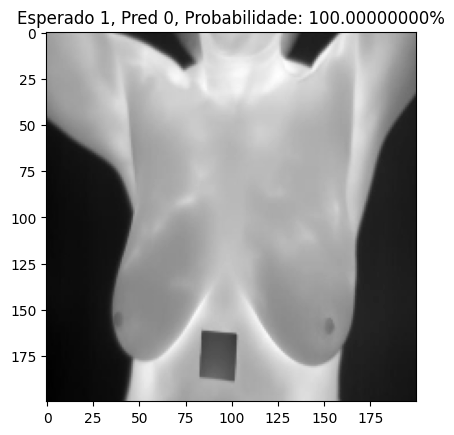

1/1 [==============================] - 0s 15ms/step


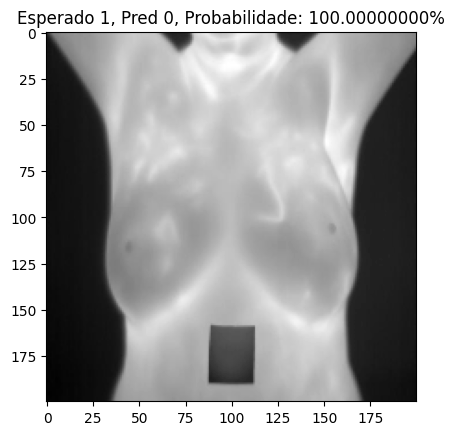

1/1 [==============================] - 0s 14ms/step


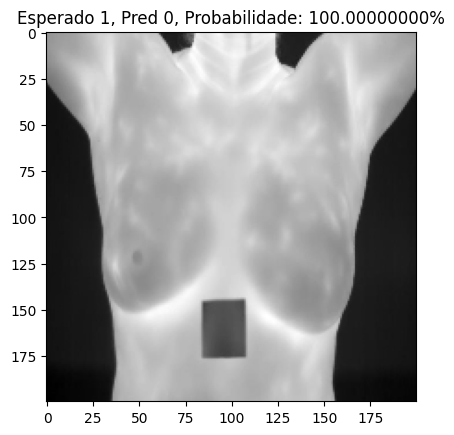

1/1 [==============================] - 0s 15ms/step


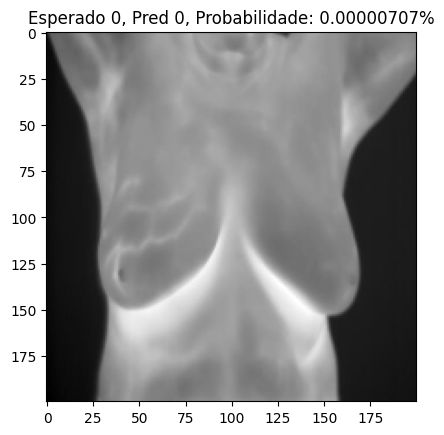

1/1 [==============================] - 0s 13ms/step


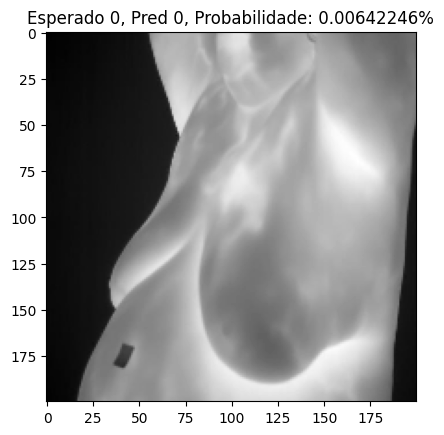

1/1 [==============================] - 0s 15ms/step


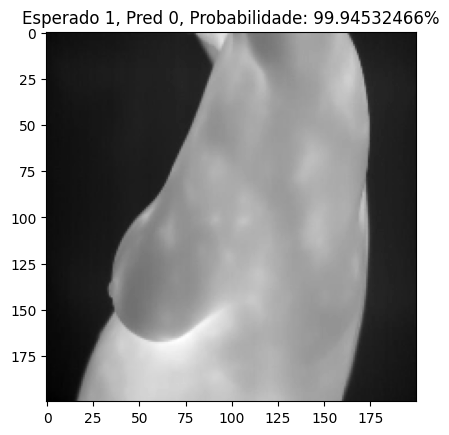

1/1 [==============================] - 0s 15ms/step


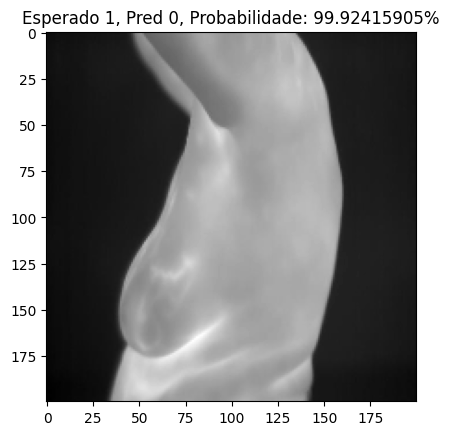

1/1 [==============================] - 0s 14ms/step


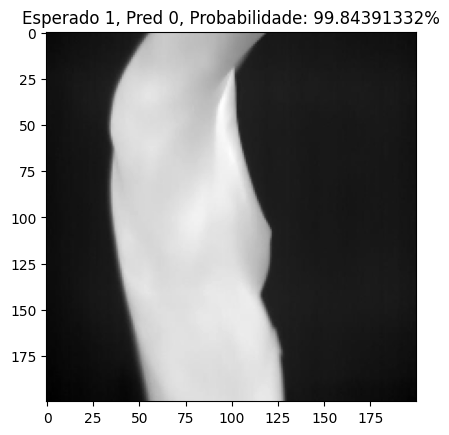

1/1 [==============================] - 0s 15ms/step


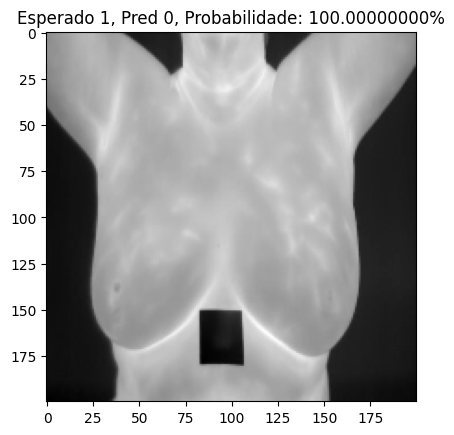

1/1 [==============================] - 0s 14ms/step


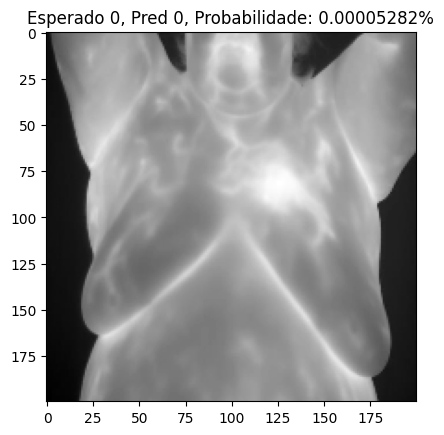

1/1 [==============================] - 0s 17ms/step


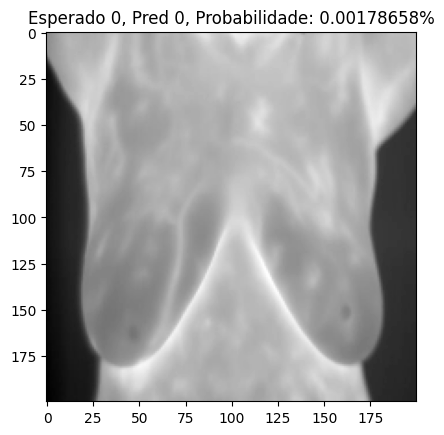

1/1 [==============================] - 0s 15ms/step


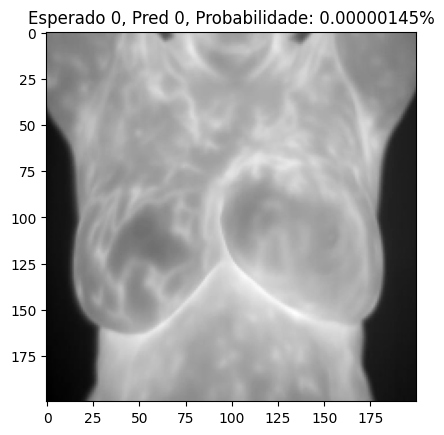

1/1 [==============================] - 0s 15ms/step


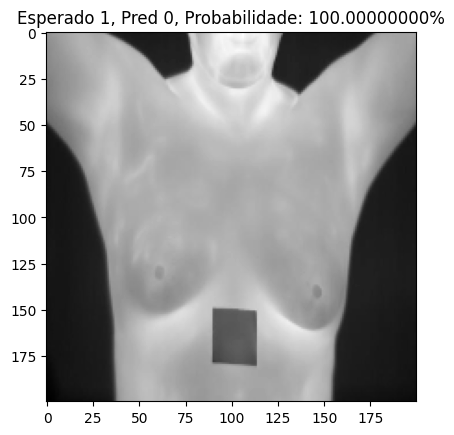

1/1 [==============================] - 0s 15ms/step


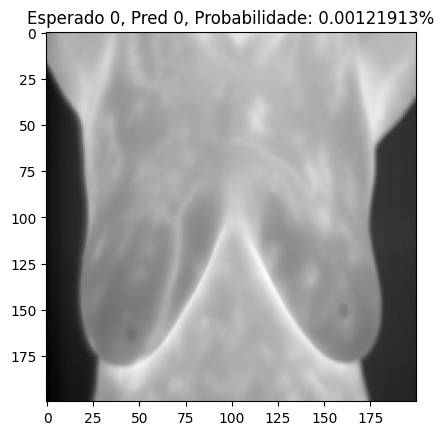

1/1 [==============================] - 0s 14ms/step


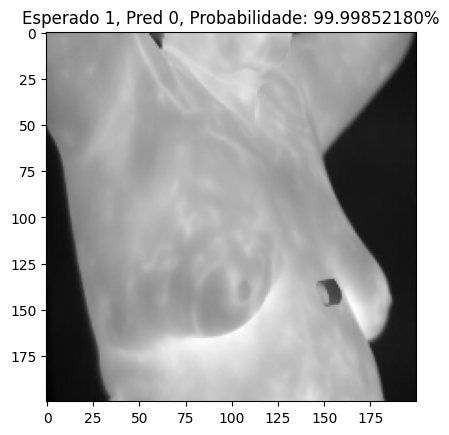

In [76]:
for idx in range(15):
    x=X_train_norm[idx].reshape(-1,IMG_SIZE,IMG_SIZE,1)
    plt.imshow(X_train_norm[idx].reshape(IMG_SIZE,IMG_SIZE), cmap='gray')
    pred = model.predict(x)
    pred_class= pred.argmax()
    plt.title(f'Esperado {y[idx]}, Pred {pred_class}, Probabilidade: {pred[0][pred_class]*100:.8f}%')
    plt.show()